# Exploratory Data Analysis and Model MSE Visualization
This notebook is split into two parts:
1. Data Exploration
    - Here we visualize the data that we have and see how the 3 matrices (shelved, isRead, and rating) are different
    - We also visualize the distribution of ratings across the uesrs
2. Model Exploration 
    - Here we explore our three models' MSE and compare all of them:
        1. User User (Weighted and Unweighted)
        2. Matrix Factorization
        3. 

In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import gc
import json
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = 10,8

### Data Set Exploration

In [11]:
path = "ShrinkMatrices/"
rating = sp.load_npz(path + "rating_matrix_shrunk.npz")
isRead = sp.load_npz(path + "isRead_matrix_shrunk.npz")
shelved = sp.load_npz(path + "shelved_matrix_shrunk.npz")

rating Matrix Sparsity: 0.019684272300469485
isRead Matrix Sparsity: 0.020527582159624413
shelved Matrix Sparsity: 0.029985915492957746


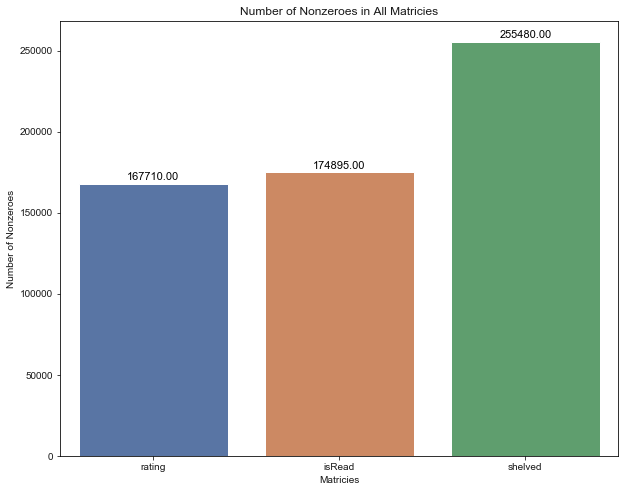

In [12]:
rating_nonzero = np.count_nonzero(rating.todense())
isRead_nonzero = np.count_nonzero(isRead.todense())
shelved_nonzero = np.count_nonzero(shelved.todense())
data = {'rating' : rating_nonzero, 'isRead' : isRead_nonzero, 'shelved' : shelved_nonzero }
data = pd.DataFrame(data, index = (0,1,2))
print ("rating Matrix Sparsity: "+ str(rating_nonzero / (rating.todense().shape[0] * rating.todense().shape[1])))
print ("isRead Matrix Sparsity: "+ str(isRead_nonzero / (isRead.todense().shape[0] * isRead.todense().shape[1])))
print ("shelved Matrix Sparsity: "+ str(shelved_nonzero / (isRead.todense().shape[0] * isRead.todense().shape[1])))
plt.figure(figsize=(10,8))
plt.title("Number of Nonzeroes in All Matricies")
plt.xlabel("Matricies")
plt.ylabel("Number of Nonzeroes")
sns.set(style="whitegrid")
ax = sns.barplot(data=data)
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 7),
                 textcoords='offset points')

As we can see, the shelved matrix has much more nonzeroes than the other two matricies. This makes sense becuase this means that a lot of users attempted to read the book but never finished reading it. The isRead matrix is slightly more than the rating matrix which also makes sense because this means that 174895 people finished reading the book, but there's a small percentage of people that didn't go rate the book.

There are 3 books that have no ratings at all.


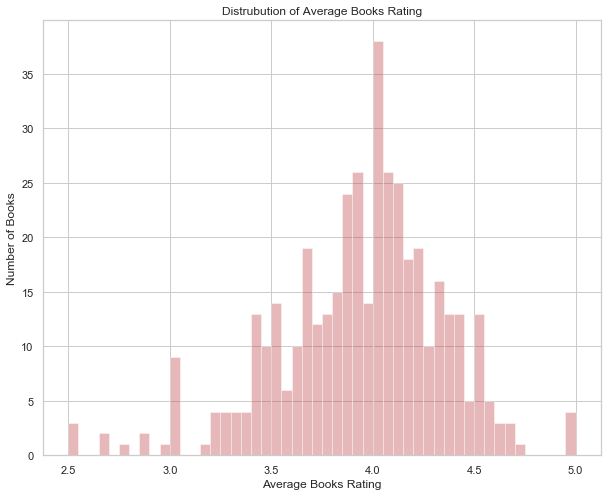

In [13]:
#temporarily replace 0 with nan so that 0's aren't calculated in the mean
rating_pd = pd.DataFrame(rating.todense())
book_avg = pd.Series(rating_pd.replace(0, np.nan).mean())

#drop the na's because that just means the book has never been rated before
plt.figure(figsize=(10,8))
number_NA = book_avg.isna().sum()
book_avg = book_avg.dropna()
print ("There are " + str(number_NA) + " books that have no ratings at all.")
plt.title("Distrubution of Average Books Rating")
plt.xlabel("Average Books Rating")
plt.ylabel("Number of Books")
sns.set(style="darkgrid")
sns.distplot(book_avg, kde =  False, bins = 50, color = "r")
plt.show()

It seems like most books have a rating of between 3.5 ~ 4.5.

There are 2915 users that rated no books at all.
But that's okay, we will try to fix that by combining all three matricies together.
That way these users still have some similarity with other users that have rated books.


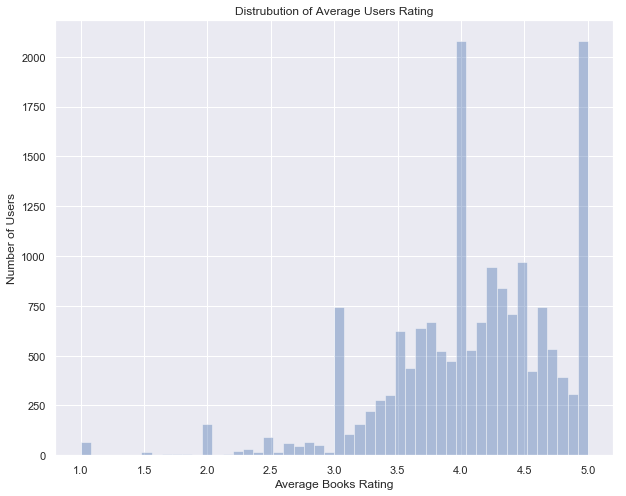

In [14]:
#temporarily replace 0 with nan so that 0's aren't calculated in the mean
user_avg = pd.Series(rating_pd.replace(0, np.nan).mean(axis = 1))

#drop the na's because that just means the book has never been rated before
number_NA = user_avg.isna().sum()
user_avg = user_avg.dropna()
plt.figure(figsize=(10,8))
print ("There are " + str(number_NA) + " users that rated no books at all.")
print ("But that's okay, we will try to fix that by combining all three matricies together.")
print ("That way these users still have some similarity with other users that have rated books.")
plt.title("Distrubution of Average Users Rating")
plt.xlabel("Average Books Rating")
plt.ylabel("Number of Users")
sns.set(style="whitegrid")
sns.distplot(user_avg, kde =  False, bins = 50)
plt.show()

There are the most users that on an average of 4.0's and most users who rate an average of 5.0. This means that these users either always rate 4 or always rate 5.

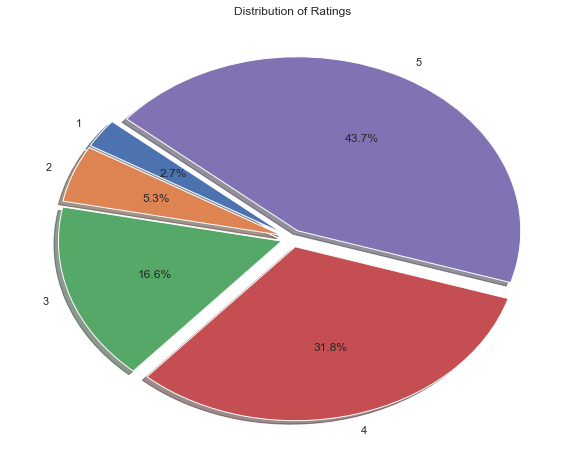

In [15]:
#count all the different numbers in the matrix
sizes = dict(zip(*np.unique(np.asarray(rating.todense()), return_counts=True)))
sizes.pop(0)
sizes = list(sizes.values())

#plot
labels = '1', '2', '3', "4", "5"
explode = (0.05,0.05,0.05,0.05,0.05)
plt.title("Distribution of Ratings")
plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

Ratings of 4 and 5 have the biggest percentage. This makese sense because if a user is able to read the book all the way, it very likely means that this book is at least above average.

# Recommender Model Exploration

### User-User Model

In [16]:
#load the json
path_user = "UserUserModel/"
sweep1 = path_user + "user_user_sweep1.json"
sweep2 = path_user + "user_user_sweep2.json"
sweep3 = path_user + "user_user_sweep3.json"
sweep4 = path_user + "user_user_sweep4.json"
sweep5 = path_user + "user_user_sweep5.json"
sweep6 = path_user + "user_user_sweep6.json"
sweep7 = path_user + "user_user_sweep7.json"

sweep1 = pd.read_json(sweep1, typ = "series")
sweep2 = pd.read_json(sweep2, typ = "series")
sweep3 = pd.read_json(sweep3, typ = "series")
sweep4 = pd.read_json(sweep4, typ = "series")
sweep5 = pd.read_json(sweep5, typ = "series")
sweep6 = pd.read_json(sweep6, typ = "series")
sweep7 = pd.read_json(sweep7, typ = "series")
sweep_all = sweep1.append(sweep2).append(sweep3).append(sweep4).append(sweep5).append(sweep6).append(sweep7)

In [17]:
sweep_all = pd.DataFrame(sweep_all)
sweep_all.rename(columns = {0 : "test"}, inplace = True)
sweep_all.head()

,test
"(0.0, 0.0)",0.975639
"(0.0, 0.1)",0.982424
"(0.0, 0.2)",0.982210
"(0.0, 0.30000000000000004)",0.981681
"(0.0, 0.4)",0.981733


Right now the json isn't parsed yet, which causes the key and regulizers to be in a tuple form. 
We need to separate this in order to be able to plot the data.

In [18]:
import ast
sweep_all = sweep_all.transpose()
columns =list(sweep_all.columns)
tuples_parseready = list(map(lambda x: tuple(ast.literal_eval(x)), columns))
w1, w2 = list(zip(*tuples_parseready))

In [19]:
user_params = pd.DataFrame({"w1": w1, "w2" : w2, "test" : sweep_all.iloc[0]}).reset_index()
user_params.head()

,index,w1,w2,test
0,"(0.0, 0.0)",0.0,0.0,0.975639
1,"(0.0, 0.1)",0.0,0.1,0.982424
2,"(0.0, 0.2)",0.0,0.2,0.982210
3,"(0.0, 0.30000000000000004)",0.0,0.3,0.981681
4,"(0.0, 0.4)",0.0,0.4,0.981733


In [20]:
user_params = user_params.drop("index", axis = 1)

In [21]:
unweighted = user_params.iloc[0]
user_params = user_params.iloc[1:]
unweighted_user_MSE = unweighted['test']
weighted_user_MSE = user_params.loc[user_params['test'].idxmin()]['test']

An unweighted model's MSE is:
MSE = 0.9756388191656601
----------------------------------------------
Params with lowest test data MSE's are:
w1 = 0.0
w2 = 3.6
MSE = 0.9764699310892011


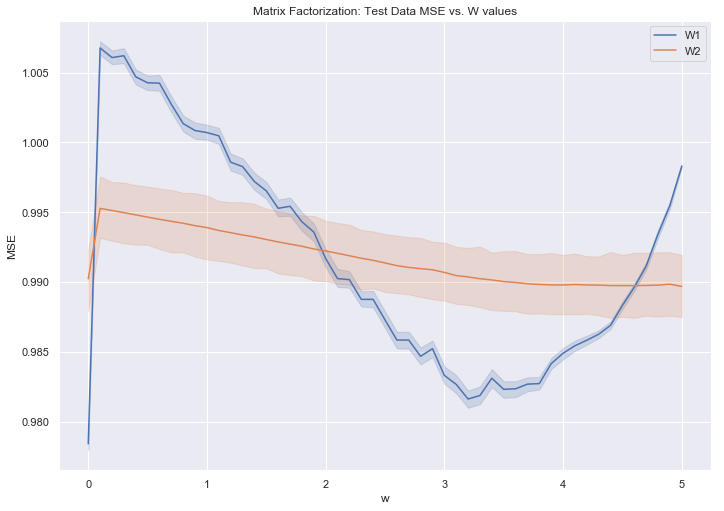

In [22]:
print ("An unweighted model's MSE is:")
print ("MSE = " + str(unweighted['test']))
print ("----------------------------------------------")
print ("Params with lowest test data MSE's are:")
print ("w1 = " + str(user_params.loc[user_params['test'].idxmin()]['w1']))
print ("w2 = " + str(user_params.loc[user_params['test'].idxmin()]['w2']))
print ("MSE = " + str(user_params.loc[user_params['test'].idxmin()]['test']))
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(user_params['w1'], user_params['test'], dashes = False, estimator = "mean")
sns.lineplot(user_params['w2'], user_params['test'], dashes = False, estimator = "mean")
plt.legend(labels = ["W1", "W2"])
plt.title("Matrix Factorization: Test Data MSE vs. W values")
plt.ylabel("MSE")
plt.xlabel("w")
plt.show()

It seems like w1's affect on the MSE changes much more as we swept through the params where as w2's effect remains almost the same throughout the sweeping from 0 to 5. However, in both cases we see that the MSE ism uch lower in the beginning and the MSE suddently spikes up at around w1 = 0.3 or w2 = 0.3, and then it starts decreasing throughout the graph.

In [23]:
user_heatmap = user_params.pivot_table(index = 'w1', columns = 'w2', values = 'test').fillna(0)
user_heatmap.head()

w2,0.0,0.1,0.2,0.30000000000000004,0.4,0.5,0.6000000000000001,0.7000000000000001,0.8,0.9,...,4.1000000000000005,4.2,4.3,4.4,4.5,4.6000000000000005,4.7,4.800000000000001,4.9,5.0
w1,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.982424,0.982210,0.981681,0.981733,0.981240,0.981032,0.980807,0.980874,0.980340,...,0.977309,0.977407,0.977413,0.977775,0.977595,0.977784,0.977802,0.977890,0.978679,0.977765
0.1,1.006447,1.009885,1.010487,1.010326,1.010151,1.009965,1.009806,1.009649,1.009484,1.009381,...,1.005001,1.005001,1.004989,1.005012,1.005181,1.005223,1.005284,1.005346,1.005442,1.005326
0.2,1.005725,1.009273,1.009142,1.009743,1.009570,1.009377,1.009218,1.009057,1.008950,1.008715,...,1.004274,1.004263,1.004220,1.004269,1.004451,1.004488,1.004556,1.004642,1.004687,1.004590
0.3,1.005422,1.009582,1.009423,1.009690,1.009862,1.009667,1.009505,1.009411,1.009167,1.008976,...,1.004270,1.004261,1.004248,1.004259,1.004470,1.004508,1.004580,1.004628,1.004709,1.004588
0.4,1.004238,1.008035,1.007935,1.007768,1.007574,1.008158,1.008078,1.007859,1.007692,1.007510,...,1.002764,1.002751,1.002767,1.002915,1.002984,1.003045,1.003082,1.003157,1.003229,1.003123


The lighter the color, the lower the MSE.
The highlighted is where the lowest MSE is at.


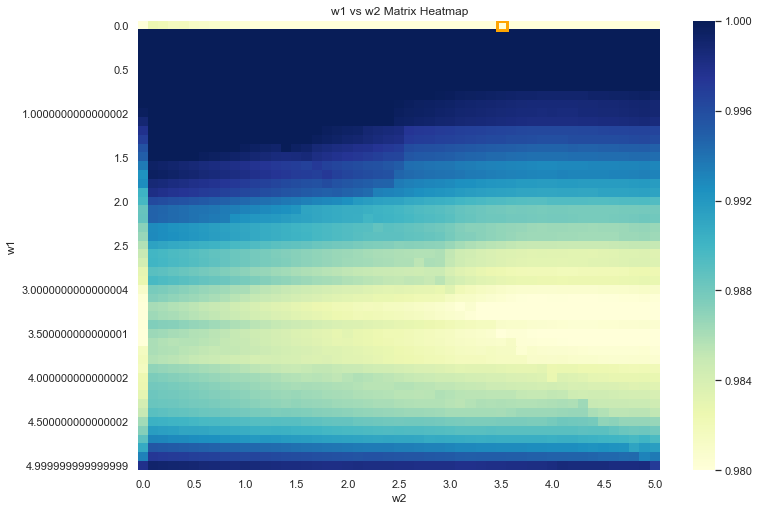

In [24]:
print ("The lighter the color, the lower the MSE.")
print ("The highlighted is where the lowest MSE is at.")
from matplotlib.patches import Rectangle

g = sns.heatmap(user_heatmap, cmap="YlGnBu", vmin = 0.98, vmax =1, xticklabels = 5, yticklabels= 5)
plt.title("w1 vs w2 Matrix Heatmap")
ax = g.axes
ax.add_patch(Rectangle((35, 0), 1, 1, fill=False, edgecolor='orange', lw=3))
plt.show()

For the majority of this matrix, most entries have higher MSE's. The lowest MSE's are either at the edge of the matrix where either w1 = 0 or w2 = 0. Perhaps what this suggests is that only one weight or one matrix is needed to be added onto the original rating matrix to create a better recommender model. There are also some lower MSE's where w2 is around 4.0 to 5.0 and w1 is around 3.5 to 4.0. 

### Matrix Factorization

In [25]:
#load the json
path2 = "MatrixFactorizationModel/"
matrix_fact = path2 + "matrix_factorization_all_params.json"
matrix_params = pd.read_json(matrix_fact)


In [26]:
matrix_params.rename(index = {0 : "train", 1:"test"}, inplace = True)
matrix_params

,"(50, 1)","(50, 2)","(50, 3)","(50, 4)","(50, 5)","(50, 6)","(50, 7)","(50, 8)","(50, 9)","(50, 10)",...,"(109, 1)","(109, 2)","(109, 3)","(109, 4)","(109, 5)","(109, 6)","(109, 7)","(109, 8)","(109, 9)","(109, 10)"
train,0.004214,0.010382,0.020872,0.034797,0.051499,0.070505,0.091465,0.114043,0.137986,0.163073,...,0.001736,0.008263,0.018870,0.032902,0.049696,0.068788,0.089801,0.112459,0.136542,0.161835
test,1.480345,1.228914,1.182379,1.170856,1.169417,1.170405,1.172987,1.177313,1.183209,1.190458,...,10.652796,3.358405,1.418198,1.192250,1.162020,1.160812,1.165734,1.172397,1.180080,1.188649


In [27]:
#Right now the json isn't parsed yet, which causes the key and regulizers to be in a tuple form. 
#We need to separate this in order to be able to plot the data.

In [28]:
import ast
columns =list(matrix_params.columns)
tuples_parseready = list(map(lambda x: tuple(ast.literal_eval(x)), columns))
K, reg = list(zip(*tuples_parseready))

In [29]:
mat_params = pd.DataFrame({"K": K, "reg" : reg, "train" : matrix_params.iloc[0], "test" : matrix_params.iloc[1]}).reset_index()

In [30]:
pd_mat = mat_params.drop("index", axis = 1)

In [31]:
#find the lowest test MSE's at every K
pd_mat = pd_mat.loc[pd_mat.groupby("K")['test'].idxmin()]
matrix_fact_MSE = pd_mat.loc[pd_mat['test'].idxmin()]['test']

Params with lowest test data MSE's are:
K = 80.0
reg = 5.0
MSE = 1.032222617050581


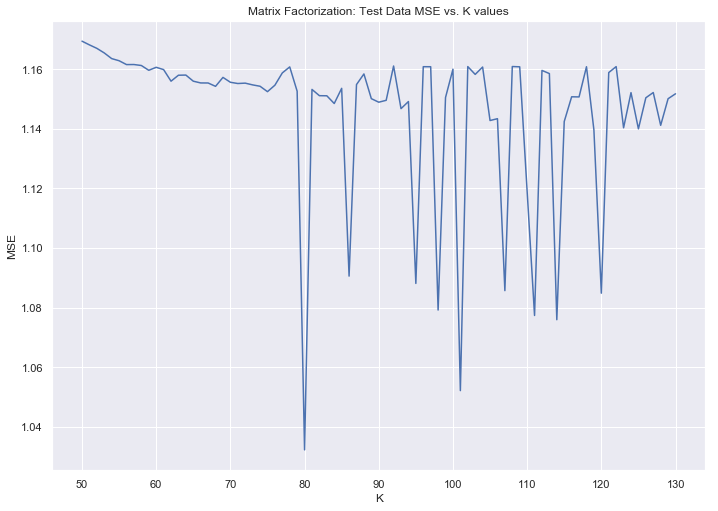

In [32]:
print ("Params with lowest test data MSE's are:")
print ("K = " + str(pd_mat.loc[pd_mat['test'].idxmin()]['K']))
print ("reg = " + str(pd_mat.loc[pd_mat['test'].idxmin()]['reg']))
print ("MSE = " + str(pd_mat.loc[pd_mat['test'].idxmin()]['test']))
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x = pd_mat['K'], y = pd_mat['test'], dashes = False, estimator = 'mean')
plt.title("Matrix Factorization: Test Data MSE vs. K values")
plt.ylabel("MSE")
plt.xlabel("K")
plt.show()

It's a good thing that we swept through the K as we can see that there is no clear pattern (decreasing or increasing) where the MSE is the loweset. We can only find out by sweeping through one by one.

In [33]:
matrix_heatmap = mat_params.pivot_table(index = 'K', columns = 'reg', values = 'test').fillna(0)
matrix_heatmap.head()

reg,1,2,3,4,5,6,7,8,9,10
K,,,,,,,,,,
50,1.480345,1.228914,1.182379,1.170856,1.169417,1.170405,1.172987,1.177313,1.183209,1.190458
51,10.874010,4.182271,1.586058,1.222800,1.174166,1.168174,1.170609,1.175825,1.182632,1.190531
52,2.429456,1.396309,1.201957,1.172909,1.167010,1.167602,1.170996,1.176048,1.182445,1.190054
53,1.363392,1.202287,1.171195,1.165712,1.165467,1.167429,1.170828,1.175733,1.182104,1.189800
54,1.427542,1.201004,1.171561,1.164343,1.163567,1.165796,1.169713,1.175001,1.181603,1.189447


The lighter the color, the lower the MSE.
The highlighted is where the lowest MSE is at.


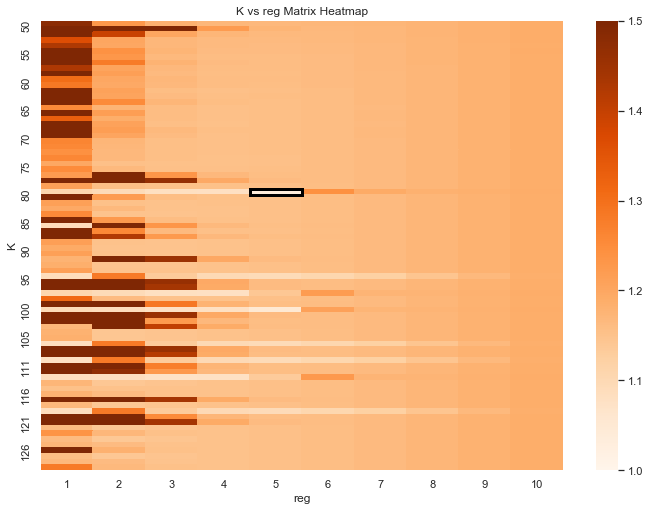

In [34]:
print ("The lighter the color, the lower the MSE.")
print ("The highlighted is where the lowest MSE is at.")
from matplotlib.patches import Rectangle

plt.show()
g = sns.heatmap(matrix_heatmap, cmap="Oranges",  vmin = 1.0, vmax = 1.5,  yticklabels = 5)
plt.title("K vs reg Matrix Heatmap")
ax = g.axes
ax.add_patch(Rectangle((4, 30), 1, 1, fill=False, edgecolor='black', lw=3))
plt.show()

The sweet spot in the matrix heat map is at reg = 5 and K = 80. It is boxed and we can see that it does have the lightest shade meaning lowest MSE.

Let's visualize how the number of iterations we decompose the rating matrix affects the Matrix Factorization model at k = 80 and reg = 5.0

In [35]:
path = "MatrixFactorizationModel/"
best_mf_param = "best_param_50_niter.npy"
mf_niters = np.load(path + best_mf_param)

In [36]:
mf_niters = pd.DataFrame({"train_error": mf_niters[0], "test_error": mf_niters[1]})
mf_niters.index = range(1, len(mf_niters.index) + 1)

The lowest MSE is at niter = 50
But we can see that it starts converging at around niter = 10


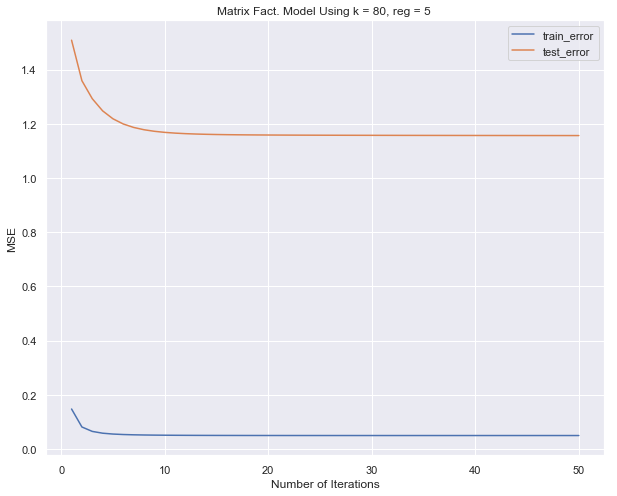

In [37]:
print ("The lowest MSE is at niter = " + str(mf_niters['test_error'].idxmin()))
print ("But we can see that it starts converging at around niter = 10")
mf_niters.plot(figsize=(10,8))
plt.title("Matrix Fact. Model Using k = 80, reg = 5 ")
plt.ylabel("MSE")
plt.xlabel("Number of Iterations")
plt.show()

The huge gap between train and test error could be a suggestion that our model is in fact way too over fitted for the train data but not that good on prediction new data sets.

### Neural Network Matrix Factorization

In [38]:
import keras
from keras.models import Model

In [39]:
#load the json
path3 = "NeuralNetworkModel/"
nn_history = path3 + "nn_history.json"
model = path3 + "nn_model"
nn_history = pd.read_json(nn_history)
model = keras.models.load_model(model)

In [40]:
nn_history

,loss,mean_absolute_error,val_mean_squared_error,val_mean_absolute_error,mean_squared_error,val_loss
0,3.300016,1.322219,1.235233,0.962521,3.300016,1.235233
1,0.534052,0.546945,1.286674,0.990096,0.534052,1.286674
2,0.277393,0.391180,1.276944,0.983130,0.277393,1.276944
3,0.173944,0.318817,1.265001,0.977165,0.173944,1.265001
4,0.137368,0.288114,1.221077,0.951745,0.137368,1.221077
5,0.118136,0.268448,1.202229,0.940443,0.118136,1.202229
6,0.107543,0.256907,1.190754,0.933154,0.107543,1.190754
7,0.098616,0.245950,1.178240,0.924962,0.098616,1.178240
8,0.092034,0.237243,1.152843,0.905754,0.092034,1.152843
9,0.086761,0.230906,1.135395,0.891492,0.086761,1.135395


In [41]:
# load dataset

npz_filename = "ShrinkMatrices/rating_matrix_shrunk.npz"

sparse_rating_matrix = sp.load_npz(npz_filename)

dense_rating_matrix = sparse_rating_matrix.todense()

# X_tr now is 1d array version of dense_rating_matrix
X_tr = np.asarray(dense_rating_matrix.copy())
X_tr = X_tr.flatten()


nonzero_pairs = np.nonzero(X_tr)[0]
num_non_zero_pairs = len(nonzero_pairs)

total_num_pairs = X_tr.shape[0]
num_testing_pairs = int(0.1 * num_non_zero_pairs)


# seeds the random generator
np.random.seed(0)

# indices of 1d array X_tr
testing_pair_indices = np.random.choice(nonzero_pairs, num_testing_pairs, replace=False)
training_pair_indices = list(set(np.arange(total_num_pairs)) - set(testing_pair_indices))


X_te = X_tr.copy()

# sets testing pairs in training set to be 0
X_tr[testing_pair_indices] = 0

# sets training pairs in testing set to be 0
X_te[training_pair_indices] = 0


# takes X_tr and X_te back to shape of dense_rating_matrix

X_tr = X_tr.reshape((dense_rating_matrix.shape[0], dense_rating_matrix.shape[1]))
X_te = X_te.reshape((dense_rating_matrix.shape[0], dense_rating_matrix.shape[1]))

nonzero_users_tr, nonzero_books_tr, nonzero_ratings_tr = sp.find(X_tr)
nonzero_users_te, nonzero_books_te, nonzero_ratings_te = sp.find(X_te)

In [42]:
predictions_te = model.predict([np.array([[user] for user in nonzero_users_te]),
                                np.array([[book] for book in nonzero_books_te])]).flatten()
nn_MSE = np.mean((predictions_te - nonzero_ratings_te) ** 2)

predictions_tr = model.predict([np.array([[user] for user in nonzero_users_tr]),
                                np.array([[book] for book in nonzero_books_tr])]).flatten()
nn_MSE_tr = np.mean((predictions_tr - nonzero_ratings_tr) ** 2)

print ("Training MSE: " + str(nn_MSE_tr))
print ("Testing MSE: " + str(nn_MSE))

Training MSE: 0.26432608179038763
Testing MSE: 0.7679610208054987


The lowest MSE is at epoch 10 with an MSE of 0.086760644356991


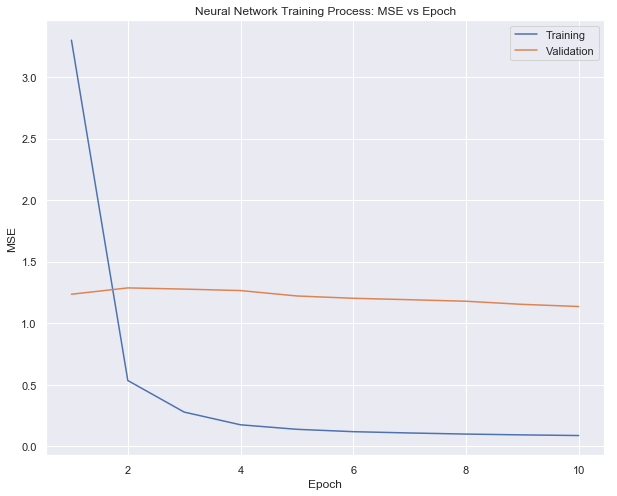

In [43]:
print ("The lowest MSE is at epoch 10 with an MSE of " + str(nn_history.loss.min()))
plt.figure(figsize= (10,8))
sns.lineplot(x = nn_history.index + 1, y = nn_history.loss, label="Training")
sns.lineplot(x = nn_history.index + 1, y = nn_history.val_mean_squared_error, label="Validation")
plt.title("Neural Network Training Process: MSE vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [44]:
all_models = {"UserUser" : unweighted_user_MSE, "WeightedUserUser": weighted_user_MSE , "MatrixFactorization": matrix_fact_MSE , 
 "NeuralNetworkMF": nn_MSE} 
all_models = pd.DataFrame(all_models, index =['Test MSE']).transpose()
all_models

,Test MSE
UserUser,0.975639
WeightedUserUser,0.976470
MatrixFactorization,1.032223
NeuralNetworkMF,0.767961


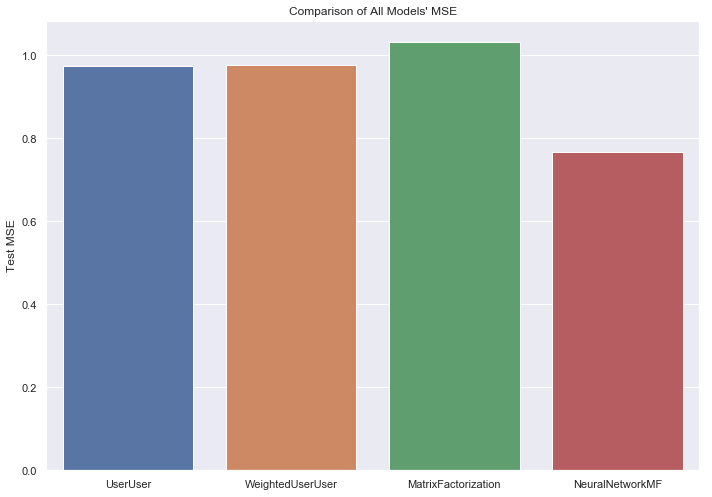

In [45]:
sns.barplot(x = all_models.index, y = all_models["Test MSE"])
plt.title("Comparison of All Models' MSE")
plt.show()

Our neuralnetworkMF model performs with the lowest MSE, but also takes the longest to train.

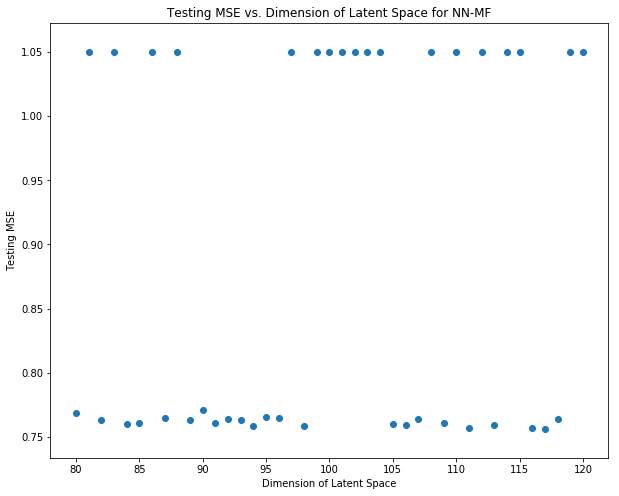

In [5]:
with open("NeuralNetworkModel/nn_sweep.json", "r") as f:
    ks_errors = json.load(f)
    
top_params = [(k, ks_errors[k]) for k in sorted(ks_errors, key=lambda k: ks_errors[k][0])]

ks = [eval(pair[0]) for pair in top_params]
mses_te = [pair[1][0] for pair in top_params] 
plt.figure(figsize = (10, 8))
plt.scatter(ks, mses_te)
plt.title("Testing MSE vs. Dimension of Latent Space for NN-MF")
plt.xlabel("Dimension of Latent Space")
plt.ylabel("Testing MSE")
plt.show()

This is a plot showing the test MSE vs. the dimension of latent space for our NN-MF model. As you can see, there is no clear pattern either. Some latent spaces just have lower MSE while others have a much higher one.